## Chapter Goals
    
    1. Use GMM to predict return distribution for chosen lookahead period
    2. Evaluate GMM accuracy in predicting confidence intervals
    3. Design and implement an event study based on "outlier" returns
    4. Evaluate Event Study
    5. Improve Model by Adding Economic Features
    6. Conclusions

In [1]:
%load_ext watermark
%watermark

from IPython.display import display

# import standard libs
from pathlib import PurePath, Path
import sys
import time
from itertools import count

# get project dir
pp = PurePath(Path.cwd()).parts[:-1]
pdir = PurePath(*pp)
script_dir = pdir / 'scripts' 
sys.path.append(script_dir.as_posix())

# import python scientific stack
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import sklearn.mixture as mix
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.model_selection import TimeSeriesSplit
import math

# import visual tools
from mpl_toolkits import mplot3d
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import plotnine as pn
import mizani.breaks as mzb
import mizani.formatters as mzf
import seaborn as sns

# import util libs
import pyarrow as pa
import pyarrow.parquet as pq
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
from utils import cprint

# set plot globals
plt.style.use('bmh') 
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 9.5
plt.rcParams['font.weight'] = 'medium'
plt.rcParams['figure.figsize'] = 10,8
#plt.rcParams['axes.facecolor'] = sns.xkcd_rgb['gunmetal']

blue, green, red, purple, gold, teal = sns.color_palette('colorblind', 6)
RANDOM_STATE = 777

print()
%watermark -p pandas,pandas_datareader,numpy,sklearn,statsmodels,scipy,matplotlib,seaborn,plotnine,mizani,pyarrow

2017-12-05T13:56:29-07:00

CPython 3.6.2
IPython 6.1.0

compiler   : GCC 4.8.2 20140120 (Red Hat 4.8.2-15)
system     : Linux
release    : 4.10.0-38-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 12
interpreter: 64bit


/home/bcr/anaconda3/envs/bayesian/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools



pandas 0.21.0
pandas_datareader 0.5.0
numpy 1.13.1
sklearn 0.19.0
statsmodels 0.8.0
scipy 1.0.0
matplotlib 2.1.0
seaborn 0.8.1
plotnine 0.3.0+9.g6519baa
mizani 0.4.2
pyarrow 0.7.1


## Using GMMs to Predict Return Distributions for Lookahead Periods

In this section we will implement a GMM to iteratively predict the distribution for our lookahead period. To do this we will make sure of `sklearn's` `TimeSeriesSplit()` function, which increments train/test data sets sequentially. This is to avoid the loss of autocorrelation information caused by using traditional cross validation techniques, which assume that the data is [IID](https://en.wikipedia.org/wiki/Independent_and_identically_distributed_random_variables). 

In [2]:
load_parquet = lambda fp: (pq.read_table(fp).to_pandas().assign(year=lambda df: df.index.year).loc['2005':])

load_fp = PurePath(pdir, 'data/etf_returns_2004-11-19-2017-09-29.parquet').as_posix()
rdf = load_parquet(load_fp)
cprint(rdf)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                 EEM       EFA       GLD       QQQ       SPY       TLT  year
Date                                                                        
2017-09-25 -0.017113 -0.005719  0.010413 -0.010588 -0.002047  0.006240  2017
2017-09-26 -0.002694 -0.002208 -0.011225  0.002588  0.000602 -0.001813  2017
2017-09-27 -0.003603  0.000737 -0.009465  0.008970  0.003887 -0.015183  2017
2017-09-28 -0.000677  0.002647  0.001884 -0.000346  0.001199 -0.002968  2017
2017-09-29  0.011447  0.005858 -0.005168  0.007176  0.003509  0.002247  2017
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3209 entries, 2005-01-03 to 2017-09-29
Data columns (total 7 columns):
EEM     3209 non-null float64
EFA     3209 non-null float64
GLD     3209 non-null float64
QQQ     3209 n

In [3]:
sym = 'SPY' # example symbol
s = rdf[sym].copy() 
s.to_frame().info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3209 entries, 2005-01-03 to 2017-09-29
Data columns (total 1 columns):
SPY    3209 non-null float64
dtypes: float64(1)
memory usage: 50.1 KB


In [4]:
#td = (s.index.max() - s.index.min()).days#/np.timedelta64(1, 'W') # number of weeks
n_split = len(s) - 1# math.ceil(td)
n_split

3208

In [79]:
### add these funcs to a model util script

def make_gmm(n_components, max_iter=150, random_state=RANDOM_STATE):
    """fn: create gmm object"""
    model_kwds = dict(n_components=n_components, 
                      max_iter=max_iter,
                      n_init=100,
                      init_params='random',
                      random_state=RANDOM_STATE)

    gmm = mix.GaussianMixture(**model_kwds)
    return gmm

In [195]:
%%time

np.random.seed(0)

lookback = 252 * 3
n_components = 1 # experiment

tscv = TimeSeriesSplit(n_splits=n_split, max_train_size=lookback)

alpha = 0.99 # for sampling confidence intervals
pred_rows = [] # init list to hold df rows
c = count(1) # init counter
for i, (train, test) in enumerate(tscv.split(s)):
    if next(c) < lookback: # add training data until min lookback
        continue

    ### set up train/test data ###
    # temp train data as pd.Series
    tmp_train = s.iloc[train]
    X_train = tmp_train.reshape(-1, 1) # must reshape for sklearn
    # temp test data as pd.Series
    #  returns pd.Series with shape (1,)
    tmp_test = s.iloc[test]
    X_test = tmp_test.reshape(1, -1) # must reshape
    
    ### fit GMM ###
    gmm = make_gmm(n_components).fit(X_train)
    hidden_states = gmm.predict(X_train) # extract hidden states
    
    ### get last state estimate ###
    last_state = hidden_states[-1]
    last_mean = gmm.means_[last_state]
    last_var = np.diag(gmm.covariances_[last_state])
    
    ### sample from distribution using last state parameters ###
    # must choose number of samples
    n_samples = 1000
    rvs = stats.norm.rvs(loc=last_mean, scale=np.sqrt(last_var), size=n_samples)
    low_ci, high_ci = stats.norm.interval(alpha=alpha, loc=np.mean(rvs), scale=np.std(rvs))
    
    ### store data into rows ###
    # columns: cols = ['Dates', 'ith_state', 'ith_ret','ith_var', 'low_ci', 'high_ci', 'actual_return']
    pred_rows.append((tmp_test.index[0], last_state, last_mean[0], last_var[0], 
                      low_ci, high_ci, X_test.ravel()[0]))    

CPU times: user 2min 53s, sys: 32 ms, total: 2min 53s
Wall time: 2min 53s


Next we create the dataframe to hold the prediction information

In [196]:
def in_range(df):
    """fn: add binary column for predictions within CI"""
    wins = df.query("low_ci < actual_return < high_ci").index
    in_list = [1 if i in wins else 0 for i in df.index]
    df = df.assign(in_range=in_list)
    return df

### make prediction df ###
cols = ['Dates', 'ith_state', 'ith_ret','ith_var', 'low_ci', 'high_ci', 'actual_return']
pred_df = (pd.DataFrame(pred_rows, columns=cols)
           .pipe(in_range))

cprint(pred_df)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
          Dates  ith_state   ith_ret   ith_var    low_ci   high_ci  \
2448 2017-09-25          0  0.000387  0.000067 -0.021124  0.021410   
2449 2017-09-26          0  0.000374  0.000067 -0.020853  0.021788   
2450 2017-09-27          0  0.000396  0.000067 -0.021067  0.022294   
2451 2017-09-28          0  0.000391  0.000067 -0.020785  0.020767   
2452 2017-09-29          0  0.000395  0.000067 -0.019158  0.020748   

      actual_return  in_range  
2448      -0.002047         1  
2449       0.000602         1  
2450       0.003887         1  
2451       0.001199         1  
2452       0.003509         1  
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2453 entries, 0 to 2452
Data columns (total 8 columns):
Dates            2453 non-null datetime64[ns]
it

Now we can plot the output and assess the accuracy of the distribution predictions.

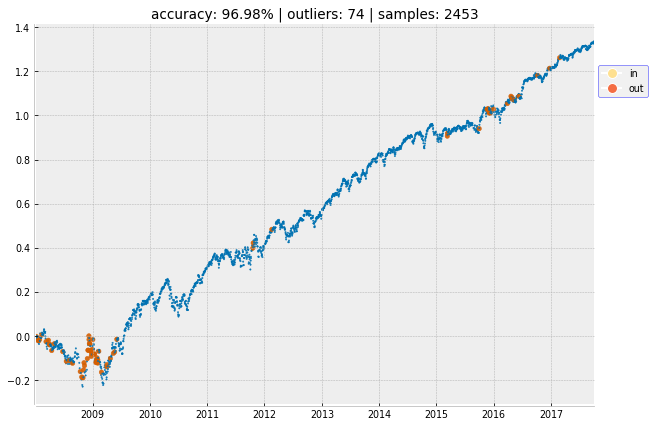

In [197]:
def plot_cuml_preds(pred_df):
    df = pred_df.set_index('Dates')
    n = df.shape[0]
    nRight = df.query('in_range==1').shape[0]
    accuracy = nRight / n
    
    colors = sns.color_palette('RdYlBu', 4)
    fig, ax = plt.subplots(figsize=(10, 7))
    marker_size = [2 if x==1 else 20 for x in df['in_range']]
    alpha_list = [0.25 if x==1 else .9 for x in df['in_range']]
    ax.scatter(df.query('in_range==1').index, df.query('in_range==1')['actual_return'].cumsum(),
               alpha=.9, s=marker_size,
               c=[blue if x == 1 else red for x in df['in_range']])

    ax.set_xlim(df.index[0], df.index[-1])

    ax.set_title(f'accuracy: {accuracy:2.2%} | outliers: {n-nRight} | samples: {n}')

    win_kwds = dict(color="white", marker='o', markersize=10)
    in_ = mpl.lines.Line2D(range(1), range(1),
        markerfacecolor=colors[1], **win_kwds)
    out_ = mpl.lines.Line2D(range(1), range(1),
        markerfacecolor=colors[0], **win_kwds)
    ci_kwds = dict(color="white", marker='.', markersize=10)
    leg = ax.legend([in_, out_], ["in", "out"],
                    loc="center left", bbox_to_anchor=(1, 0.85), numpoints=1)
    leg.get_frame().set_edgecolor('blue')
    sns.despine(offset=2)
    return 
    
    
### plot ###
from pandas.tseries import converter
converter.register()

plot_cuml_preds(pred_df)

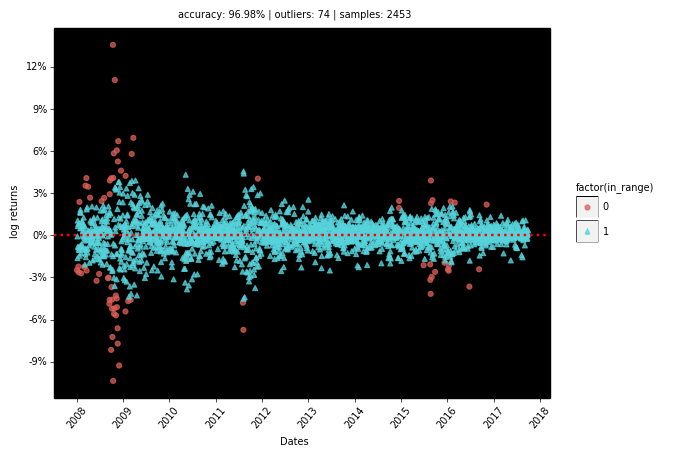

<ggplot: (-9223363304565116619)>

In [198]:
def plot_distr_accuracy(df, state_col=None):
    n = df.shape[0]
    nRight = df.query('in_range==1').shape[0]
    accuracy = nRight / n
    
    g = (pn.ggplot(df, pn.aes(x='Dates',y='actual_return', color=f'factor({state_col})')) 
         + pn.geom_point(pn.aes(shape=f'factor({state_col})'), alpha=0.75)
         + pn.geom_hline(yintercept=0., size=1, linetype=':', color='red')
         + pn.scale_y_continuous(breaks=mzb.mpl_breaks(),
                                 labels=mzf.percent_format(),
                                 limits=(df['actual_return'].min(), df['actual_return'].max()))
         + pn.scale_x_datetime(breaks=mzb.date_breaks('1 years'),
                               labels=mzf.date_format('%Y'))         
         + pn.theme_linedraw()
         + pn.theme(panel_background=pn.element_rect(fill='black'), 
                    axis_text_x=pn.element_text(rotation=50),
                    text=pn.element_text(size=7)) 
         + pn.ylab('log returns')
         + pn.ggtitle(f'accuracy: {accuracy:2.2%} | outliers: {n-nRight} | samples: {n}'))
    return g

### plot ###
plot_distr_accuracy(pred_df, 'in_range')

Naturally one may be curious how many outliers there were per period _(year, month)_ for the purposes of ascertaining how many potential trading opportunities there are assuming a trade can be entered at each outlier point.

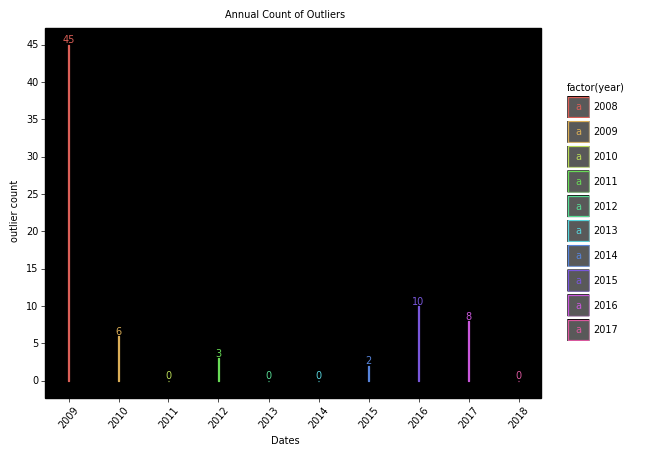

<ggplot: (-9223363304570121370)>


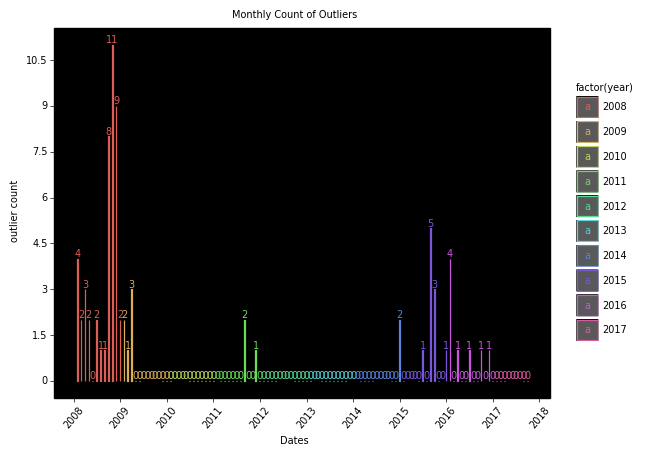

<ggplot: (8732284589853)>


In [199]:
def plot_outliers_bar(pred_df, period='A'):
    grp = pred_df.set_index('Dates').groupby([pd.TimeGrouper(period)])['in_range']  
    df = ((grp.count() - grp.sum())
          .reset_index()
          .rename(columns={'in_range':'outliers'})
          .assign(year=lambda df: df['Dates'].dt.year))

    period_map = dict(A='Annual', M='Monthly')
    dodge_text = pn.position_dodge(width=0.9)
    g = (pn.ggplot(df, pn.aes(x='Dates', y='outliers', color='factor(year)'))
         + pn.geom_bar(stat='identity', width=5.)#, position=pn.position_dodge(width=1))
         + pn.scale_y_continuous(breaks=mzb.mpl_breaks(),
                                 limits=(0, df['outliers'].max()))
         + pn.scale_x_datetime(breaks=mzb.date_breaks('1 year'),
                               labels=mzf.date_format('%Y'),)
         + pn.geom_text(pn.aes(label='outliers'),
                        position=dodge_text,
                        size=7, va='bottom')
         + pn.theme_linedraw()
         + pn.theme(panel_background=pn.element_rect(fill='black'), 
                    axis_text_x=pn.element_text(rotation=50),
                    text=pn.element_text(size=7)) 
         + pn.ylab('outlier count')
         + pn.ggtitle(f'{period_map[period]} Count of Outliers'))
    return g

### plot ###
g = plot_outliers_bar(pred_df, period='A')
g1 = plot_outliers_bar(pred_df, period='M')

print(g)
print(g1)

Let's bundle the functions under a wrapper function so we can run the same analysis with a different symbol.

In [208]:
def _in_range(df):
    """fn: add binary column for predictions within CI"""
    wins = df.query("low_ci < actual_return < high_ci").index
    in_list = [1 if i in wins else 0 for i in df.index]
    df = df.assign(in_range=in_list)
    return df

def _make_pred_df(pred_rows):
    """fn: make pred df after walkforward"""
    cols = ['Dates', 'ith_state', 'ith_ret','ith_var', 'low_ci', 'high_ci', 'actual_return']
    pred_df = (pd.DataFrame(pred_rows, columns=cols)
               .pipe(_in_range))
    return pred_df

def walkforward(ts, tscv, n_components, alpha):
    """fn: implements walkforward cross validation on a single timeseries
            to predict the distribution of returns 1 step ahead
    # args
        ts : pd.Series(), index='Dates', values=symbol
        tscv : sklearn TimeSeriesSplit Object
        n_components : int(), number of Gaussian distributions to fit to data
        alpha : float(), between 0,1 for sampling confidence intervals
        
    """
    pred_rows = [] # init list to hold df rows
    c = count(1) # init counter
    for i, (train, test) in enumerate(tscv.split(s)):
        if next(c) < lookback: # add training data until min lookback
            continue

        ### set up train/test data ###
        # temp train data as pd.Series
        tmp_train = s.iloc[train]
        X_train = tmp_train.reshape(-1, 1) # must reshape for sklearn
        # temp test data as pd.Series
        #  returns pd.Series with shape (1,)
        tmp_test = s.iloc[test]
        X_test = tmp_test.reshape(1, -1) # must reshape

        ### fit GMM ###
        gmm = make_gmm(n_components).fit(X_train)
        hidden_states = gmm.predict(X_train) # extract hidden states

        ### get last state estimate ###
        last_state = hidden_states[-1]
        last_mean = gmm.means_[last_state]
        last_var = np.diag(gmm.covariances_[last_state])

        ### sample from distribution using last state parameters ###
        # must choose number of samples
        n_samples = 1000
        rvs = stats.norm.rvs(loc=last_mean, scale=np.sqrt(last_var), size=n_samples)
        low_ci, high_ci = stats.norm.interval(alpha=alpha, loc=np.mean(rvs), scale=np.std(rvs))

        ### store data into rows ###
        # columns: cols = ['Dates', 'ith_state', 'ith_ret','ith_var', 'low_ci', 'high_ci', 'actual_return']
        pred_rows.append((tmp_test.index[0], last_state, last_mean[0], last_var[0], 
                          low_ci, high_ci, X_test.ravel()[0]))    
        
    pred_df = _make_pred_df(pred_rows)
    return pred_df

### plot ###

def plot_all(pred_df):
    plot_cuml_preds(pred_df)
    g = plot_distr_accuracy(pred_df, 'in_range')
    g1 = plot_outliers_bar(pred_df, period='A')
    g2 = plot_outliers_bar(pred_df, period='M')

    print(g)
    print(g1)
    print(g2)

In [216]:
def make_ic_series(list_of_tups, name=None):
    """fn: convert list of tuples for 
            information criterion (aic, bic) into series
    # args
        list_of_tups : list() of tuples()
            tuple[0] is n_component, tuple[1] is IC
        name : str(), name of IC
    
    # returns
        s : pd.Series()
            index is n_components, values are IC's
    """
    s = (pd.DataFrame(list_of_tups)
          .rename(columns={0:'n_components', 1:name})
          .set_index('n_components')
          .squeeze())
    return s

CPU times: user 4min, sys: 16min 15s, total: 20min 15s
Wall time: 1min 46s


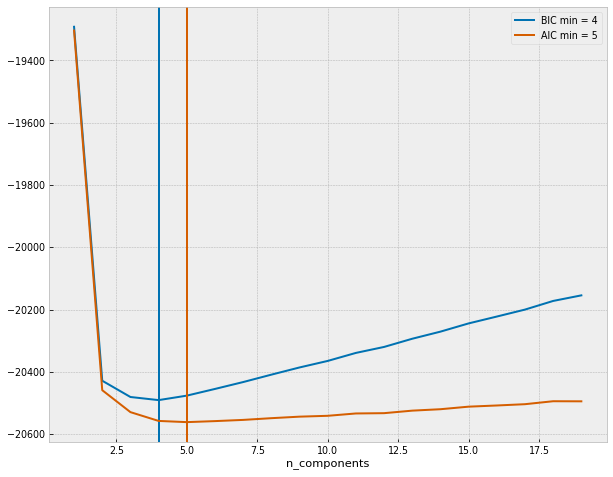

In [391]:
%%time

np.random.seed(0)

sym='SPY'
s = rdf[sym].copy()
_X = s.reshape(-1, 1)

n_components = np.arange(1,20)
aics = []
bics = []

for n in n_components:
    tmp_gmm = make_gmm(n, 150).fit(_X)
    aics.append((n, tmp_gmm.aic(_X)))
    bics.append((n, tmp_gmm.bic(_X)))

bics = make_ic_series(bics, 'bic')
aics = make_ic_series(aics, 'aic')
    
plt.plot(n_components, bics.values, color=blue, label=f'BIC min = {np.argmin(bics)}')
plt.axvline(np.argmin(bics), color=blue)

plt.plot(n_components, aics.values, color=red, label=f'AIC min = {np.argmin(aics)}')
plt.axvline(np.argmin(aics), color=red)

plt.legend(loc='best')
plt.xlabel('n_components');

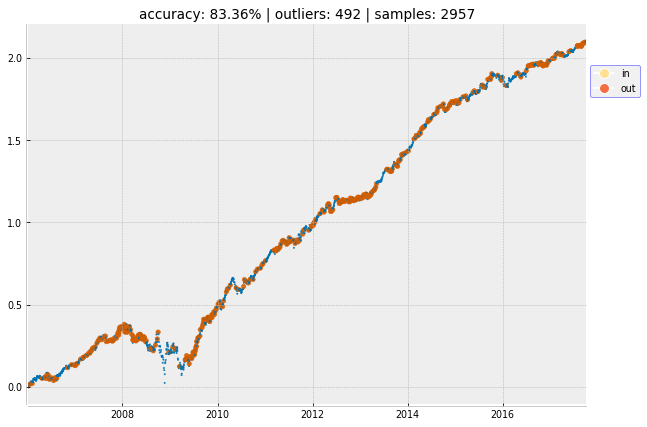

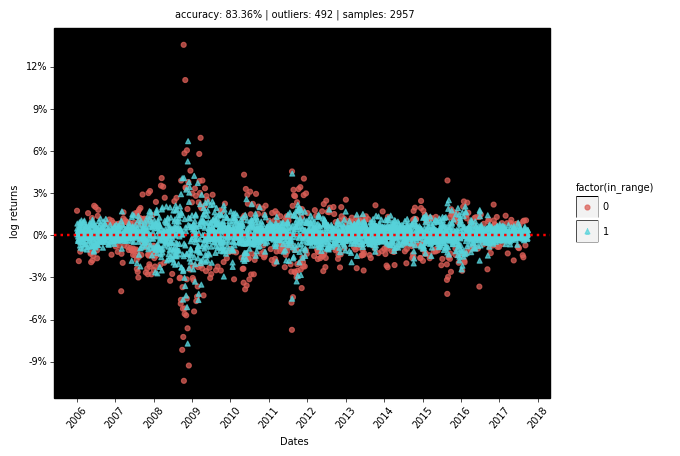

<ggplot: (8732283919031)>


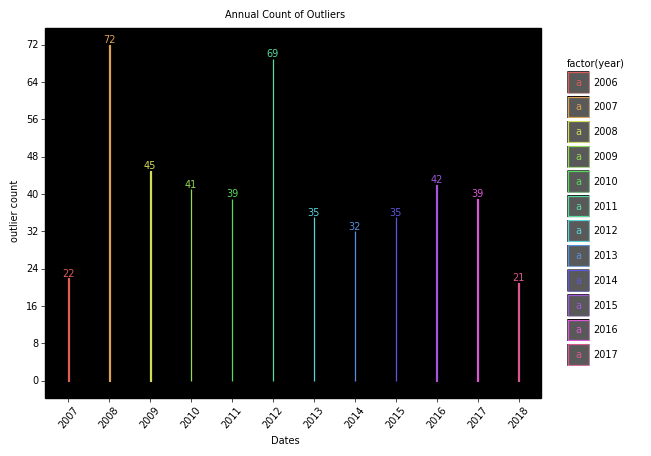

<ggplot: (8732283944547)>


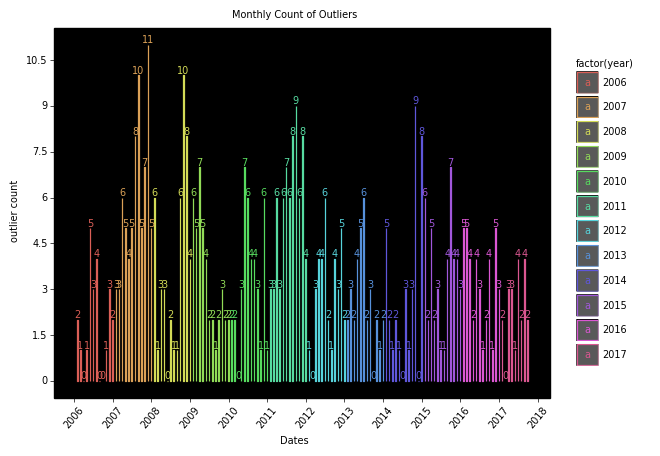

<ggplot: (-9223363304569757871)>
CPU times: user 22min 53s, sys: 1.93 s, total: 22min 55s
Wall time: 22min 53s


In [392]:
%%time

np.random.seed(0)

lookback = 252 * 1
n_components = 4 # experiment
n_split = (len(s) - 1) #// 3 # save time

tscv = TimeSeriesSplit(n_splits=n_split, max_train_size=lookback)

alpha = 0.95 # for sampling confidence intervals

pred_df = walkforward(s, tscv, n_components, alpha)
plot_all(pred_df)

Very interesting that the accuracy of the return distribution prediction is better with less components. Although one could reason that with multiple distributions, when the incorrect component parameters are used to seed the distribution sampling that the errors/outliers can be compounded, but then what would be the purpose of using a "mixture" at all? Let's see if the event study can add clarity to this question.

In [393]:
## build event study to determine the effects of the number of components in terms of returns post event

def get_outlier_direction(df):
    """"""
    direction = []
    for row in df[['high_ci', 'actual_return']].itertuples(index=False):
        if row[-1] > row[0]: # actual_returns > high_ci
            direction.append('too_high')
        else: 
            direction.append('too_low')
    df = df.assign(direction=direction)
    return df

## make outliers ##
outliers = (pred_df.query('in_range==0').pipe(get_outlier_direction))
outliers.head()

,Dates,ith_state,ith_ret,ith_var,low_ci,high_ci,actual_return,in_range,direction
0,2006-01-03,0,-0.000176,0.000045,-0.013411,0.012453,0.017436,0,too_high
12,2006-01-20,2,0.000847,0.000036,-0.011317,0.012608,-0.018406,0,too_low
21,2006-02-02,3,0.000914,0.000037,-0.010503,0.012601,-0.011673,0,too_low
72,2006-04-18,3,0.001206,0.000033,-0.009801,0.012024,0.015732,0,too_high
89,2006-05-11,2,0.000657,0.000032,-0.010075,0.011750,-0.012145,0,too_low


In [394]:
def get_post_outlier_returns(df, lookahead, direction):
    """fn: accumulate post outlier cuml. returns"""
    trade_entry_dt = pd.Timedelta('1D') # assumes daily resolution
    post_event_returns = []
    for i in outliers.query(f'direction=="{direction}"')['Dates']:
        tmp_cml = pred_df.set_index('Dates').loc[i+trade_entry_dt:i+lookahead]['actual_return'].cumsum() 
        post_event_returns.append((i, tmp_cml.iloc[-1]))
    df = (pd.DataFrame(post_event_returns, 
                       columns=['Dates','cuml_returns']))
    return df

lookahead = pd.Timedelta('5 days')
too_high_returns = get_post_outlier_returns(pred_df, lookahead, 'too_high')
too_low_returns = get_post_outlier_returns(pred_df, lookahead, 'too_low')

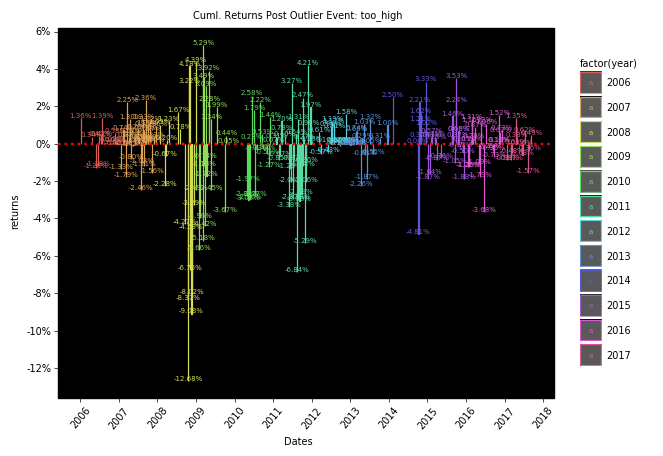

<ggplot: (8732284811675)>


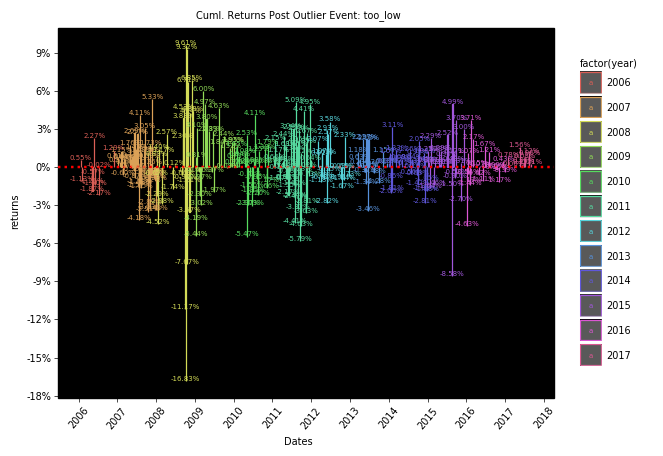

<ggplot: (8732284973355)>


In [395]:
def plot_post_outliers_bar(post_df, direction):
 
    df = (post_df.assign(year=lambda df: df['Dates'].dt.year))

    dodge_text = pn.position_dodge(width=0.9)
    g = (pn.ggplot(df, pn.aes(x='Dates', y='cuml_returns', color='factor(year)'))
         + pn.geom_bar(stat='identity')#, width=5.)#, position=pn.position_dodge(width=1))
         + pn.geom_hline(yintercept=0., size=1, linetype=':', color='red')
         + pn.scale_y_continuous(breaks=mzb.mpl_breaks(),
                                 labels=mzf.percent_format(),
                                 limits=(df['cuml_returns'].min(), df['cuml_returns'].max()))
         + pn.scale_x_datetime(breaks=mzb.date_breaks('1 year'),
                               labels=mzf.date_format('%Y'),)
         + pn.geom_text(pn.aes(label='cuml_returns'),
                        position=dodge_text,
                        size=5, va='bottom', format_string='{:.2%}')
         + pn.theme_linedraw()
         + pn.theme(panel_background=pn.element_rect(fill='black'), 
                    axis_text_x=pn.element_text(rotation=50),
                    text=pn.element_text(size=7)) 
         + pn.ylab('returns')
         + pn.ggtitle(f'Cuml. Returns Post Outlier Event: {direction}'))
    return g

### plot ###
g = plot_post_outliers_bar(too_high_returns, 'too_high')
g1 = plot_post_outliers_bar(too_low_returns, 'too_low')
print(g); print(g1)

Note that in this event study, we assume a trade cannot be entered into until `1` day after the signal is generated. If you remove the `trade_entry_dt` within the `get_post_outlier_returns` function, the returns are much more favorable. See the example below:

In [ ]:
def get_post_outlier_returns2(df, lookahead, direction):
    """fn: accumulate post outlier cuml. returns"""
    trade_entry_dt = pd.Timedelta('1D') # example with this removed 
    post_event_returns = []
    for i in outliers.query(f'direction=="{direction}"')['Dates']:
        #tmp_cml = pred_df.set_index('Dates').loc[i+trade_entry_dt:i+lookahead]['actual_return'].cumsum()
        tmp_cml = pred_df.set_index('Dates').loc[i:i+lookahead]['actual_return'].cumsum() 
        post_event_returns.append((i, tmp_cml.iloc[-1]))
    df = (pd.DataFrame(post_event_returns, 
                       columns=['Dates','cuml_returns']))
    return df

lookahead = pd.Timedelta('5 days')
### plot ###
g = plot_post_outliers_bar(get_post_outlier_returns2(pred_df, lookahead, 'too_high'), 'too_high')
g1 = plot_post_outliers_bar(get_post_outlier_returns2(pred_df, lookahead, 'too_low'), 'too_low')
print(g); print(g1)

What is happening here? This is an indication that most of trade gains occur overnight when the market is closed e.g. a gap up/down, or intraday, neither of which are captured by this event study. These types of issues require careful testing in the backtesting environment to really determine if a strategy can be implemented or if it is really just *theoretical*.

In [396]:
cprint(too_low_returns)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
         Dates  cuml_returns
271 2017-06-29      0.003557
272 2017-07-06      0.006795
273 2017-08-10      0.011218
274 2017-08-17      0.009621
275 2017-09-05      0.002111
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276 entries, 0 to 275
Data columns (total 2 columns):
Dates           276 non-null datetime64[ns]
cuml_returns    276 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 4.4 KB
None
-------------------------------------------------------------------------------



In [380]:
def sdescribe(df):
    t = df.describe().copy()
    t.loc['sum'] = df.sum().values[0]
    t.loc['median'] = df.median().values[0]
    t.loc['max_ratio'] = t.loc['max'].abs() / t.loc['min'].abs()
    t.loc['pct_neg'] = df.query('cuml_returns < 0').shape[0] / df.shape[0]
    t.loc['pct_pos'] = 1 - t.loc['pct_neg']
    return t

display(sdescribe(too_low_returns)), display(sdescribe(too_high_returns))

,cuml_returns
count,249.000000
mean,-0.001230
std,0.023737
min,-0.138062
25%,-0.012365
50%,0.001667
75%,0.012600
max,0.058271
sum,-0.306267
median,0.001667


,cuml_returns
count,191.000000
mean,0.001241
std,0.020110
min,-0.081132
25%,-0.010734
50%,0.001565
75%,0.012212
max,0.123254
sum,0.237013
median,0.001565


(None, None)

In [381]:

display(sdescribe(too_low_returns.set_index('Dates').loc['2010':])), display(sdescribe(too_high_returns.set_index('Dates').loc['2010':]))

,cuml_returns
count,168.000000
mean,-0.000891
std,0.021785
min,-0.138062
25%,-0.009348
50%,0.002658
75%,0.009970
max,0.043789
sum,-0.149668
median,0.002658


,cuml_returns
count,133.000000
mean,-0.000381
std,0.014069
min,-0.039336
25%,-0.010265
50%,0.000669
75%,0.010485
max,0.026599
sum,-0.050683
median,0.000669


(None, None)

In [390]:
looks = [4,5,7,10,21,30,42,63,120]
res = {}

for l in looks:
    try:
        lookahead = pd.Timedelta(f'{l} days')
        too_high_returns = get_post_outlier_returns(pred_df, lookahead, 'too_high')
        too_low_returns = get_post_outlier_returns(pred_df, lookahead, 'too_low')

        print('-'*50)
        print('all returns')
        print(f'## too low, lookahead = {l} ##')
        tl = sdescribe(too_low_returns)
        res[f'all_too_low_{l}'] = tl
        display(tl),
        print(f'## too high, lookahead = {l} ##')
        th = sdescribe(too_high_returns)
        res[f'all_too_high_{l}'] = th
        display(th)


        print('-'*50)
        print('post 2009 returns')
        print(f'## post too low, lookahead = {l} ##')
        tl_10 = sdescribe(too_low_returns.set_index('Dates').loc['2010':])
        display(tl_10),
        res[f'post_too_low_{l}'] = tl_10   
        print(f'## post too high , lookahead = {l} ##')
        th_10 = sdescribe(too_high_returns.set_index('Dates').loc['2010':])
        display(th_10)
        res[f'post_too_high_{l}'] = th_10
    except Exception as e:
        print(e)

--------------------------------------------------
all returns
## too low, lookahead = 4 ##


,cuml_returns
count,249.000000
mean,-0.000668
std,0.020589
min,-0.081159
25%,-0.010220
50%,0.000283
75%,0.012213
max,0.049069
sum,-0.166431
median,0.000283


## too high, lookahead = 4 ##


,cuml_returns
count,191.000000
mean,0.000790
std,0.016463
min,-0.081132
25%,-0.007362
50%,0.001423
75%,0.011251
max,0.043721
sum,0.150830
median,0.001423


--------------------------------------------------
post 2009 returns
## post too low, lookahead = 4 ##


,cuml_returns
count,168.000000
mean,0.000073
std,0.018389
min,-0.081159
25%,-0.007510
50%,0.001865
75%,0.011743
max,0.041815
sum,0.012217
median,0.001865


## post too high , lookahead = 4 ##


,cuml_returns
count,133.000000
mean,0.000628
std,0.013176
min,-0.039336
25%,-0.006838
50%,-0.000290
75%,0.010312
max,0.037928
sum,0.083566
median,-0.000290


--------------------------------------------------
all returns
## too low, lookahead = 5 ##


,cuml_returns
count,249.000000
mean,-0.001230
std,0.023737
min,-0.138062
25%,-0.012365
50%,0.001667
75%,0.012600
max,0.058271
sum,-0.306267
median,0.001667


## too high, lookahead = 5 ##


,cuml_returns
count,191.000000
mean,0.001241
std,0.020110
min,-0.081132
25%,-0.010734
50%,0.001565
75%,0.012212
max,0.123254
sum,0.237013
median,0.001565


--------------------------------------------------
post 2009 returns
## post too low, lookahead = 5 ##


,cuml_returns
count,168.000000
mean,-0.000891
std,0.021785
min,-0.138062
25%,-0.009348
50%,0.002658
75%,0.009970
max,0.043789
sum,-0.149668
median,0.002658


## post too high , lookahead = 5 ##


,cuml_returns
count,133.000000
mean,-0.000381
std,0.014069
min,-0.039336
25%,-0.010265
50%,0.000669
75%,0.010485
max,0.026599
sum,-0.050683
median,0.000669


--------------------------------------------------
all returns
## too low, lookahead = 7 ##


,cuml_returns
count,249.000000
mean,-0.001110
std,0.029257
min,-0.126252
25%,-0.014698
50%,0.001530
75%,0.018644
max,0.087962
sum,-0.276505
median,0.001530


## too high, lookahead = 7 ##


,cuml_returns
count,191.000000
mean,0.002577
std,0.025064
min,-0.065394
25%,-0.010009
50%,0.002045
75%,0.017307
max,0.129320
sum,0.492222
median,0.002045


--------------------------------------------------
post 2009 returns
## post too low, lookahead = 7 ##


,cuml_returns
count,168.000000
mean,-0.000606
std,0.026113
min,-0.126252
25%,-0.012895
50%,0.000960
75%,0.018268
max,0.049882
sum,-0.101740
median,0.000960


## post too high , lookahead = 7 ##


,cuml_returns
count,133.000000
mean,0.000679
std,0.019388
min,-0.059729
25%,-0.009901
50%,-0.000917
75%,0.014339
max,0.053142
sum,0.090269
median,-0.000917


--------------------------------------------------
all returns
## too low, lookahead = 10 ##


,cuml_returns
count,249.000000
mean,-0.000044
std,0.033362
min,-0.106873
25%,-0.017255
50%,-0.000484
75%,0.021381
max,0.116955
sum,-0.011021
median,-0.000484


## too high, lookahead = 10 ##


,cuml_returns
count,191.000000
mean,0.001906
std,0.031906
min,-0.151634
25%,-0.016305
50%,0.003495
75%,0.020981
max,0.165862
sum,0.363967
median,0.003495


--------------------------------------------------
post 2009 returns
## post too low, lookahead = 10 ##


,cuml_returns
count,168.000000
mean,-0.002353
std,0.029911
min,-0.106873
25%,-0.016246
50%,-0.003041
75%,0.019055
max,0.075657
sum,-0.395360
median,-0.003041


## post too high , lookahead = 10 ##


,cuml_returns
count,133.000000
mean,0.000005
std,0.027023
min,-0.151634
25%,-0.014738
50%,0.003196
75%,0.018522
max,0.061497
sum,0.000654
median,0.003196


--------------------------------------------------
all returns
## too low, lookahead = 21 ##


,cuml_returns
count,249.000000
mean,0.001108
std,0.048959
min,-0.154031
25%,-0.024647
50%,0.003989
75%,0.031878
max,0.152884
sum,0.275886
median,0.003989


## too high, lookahead = 21 ##


,cuml_returns
count,191.000000
mean,0.001230
std,0.046506
min,-0.171474
25%,-0.024172
50%,0.002248
75%,0.027145
max,0.118064
sum,0.234855
median,0.002248


--------------------------------------------------
post 2009 returns
## post too low, lookahead = 21 ##


,cuml_returns
count,168.000000
mean,-0.000426
std,0.041164
min,-0.125336
25%,-0.026277
50%,0.003820
75%,0.027992
max,0.098115
sum,-0.071573
median,0.003820


## post too high , lookahead = 21 ##


,cuml_returns
count,133.000000
mean,-0.003511
std,0.035630
min,-0.136874
25%,-0.024424
50%,-0.000840
75%,0.020275
max,0.095299
sum,-0.466905
median,-0.000840


--------------------------------------------------
all returns
## too low, lookahead = 30 ##


,cuml_returns
count,249.000000
mean,0.001812
std,0.056237
min,-0.196011
25%,-0.030882
50%,0.003802
75%,0.032267
max,0.161538
sum,0.451081
median,0.003802


## too high, lookahead = 30 ##


,cuml_returns
count,191.000000
mean,-0.002542
std,0.056514
min,-0.190955
25%,-0.034190
50%,-0.003764
75%,0.034386
max,0.138730
sum,-0.485463
median,-0.003764


--------------------------------------------------
post 2009 returns
## post too low, lookahead = 30 ##


,cuml_returns
count,168.000000
mean,0.000307
std,0.045585
min,-0.121005
25%,-0.030734
50%,0.000815
75%,0.027202
max,0.138980
sum,0.051627
median,0.000815


## post too high , lookahead = 30 ##


,cuml_returns
count,133.000000
mean,-0.007438
std,0.045703
min,-0.147822
25%,-0.034280
50%,-0.007323
75%,0.020869
max,0.096424
sum,-0.989275
median,-0.007323


--------------------------------------------------
all returns
## too low, lookahead = 42 ##


,cuml_returns
count,249.000000
mean,0.005392
std,0.061525
min,-0.166114
25%,-0.029435
50%,0.005580
75%,0.044913
max,0.190727
sum,1.342683
median,0.005580


## too high, lookahead = 42 ##


,cuml_returns
count,191.000000
mean,-0.008113
std,0.066158
min,-0.196647
25%,-0.043800
50%,-0.007897
75%,0.032097
max,0.209631
sum,-1.549666
median,-0.007897


--------------------------------------------------
post 2009 returns
## post too low, lookahead = 42 ##


,cuml_returns
count,168.000000
mean,0.000011
std,0.054152
min,-0.133276
25%,-0.030870
50%,-0.001761
75%,0.040893
max,0.146715
sum,0.001930
median,-0.001761


## post too high , lookahead = 42 ##


,cuml_returns
count,133.000000
mean,-0.014815
std,0.051178
min,-0.153464
25%,-0.039745
50%,-0.013431
75%,0.017713
max,0.100184
sum,-1.970343
median,-0.013431


--------------------------------------------------
all returns
## too low, lookahead = 63 ##


,cuml_returns
count,249.000000
mean,0.009656
std,0.069885
min,-0.195736
25%,-0.037216
50%,0.002195
75%,0.056156
max,0.265481
sum,2.404369
median,0.002195


## too high, lookahead = 63 ##


,cuml_returns
count,191.000000
mean,-0.007302
std,0.070312
min,-0.200145
25%,-0.054363
50%,-0.012458
75%,0.037656
max,0.177445
sum,-1.394660
median,-0.012458


--------------------------------------------------
post 2009 returns
## post too low, lookahead = 63 ##


,cuml_returns
count,168.000000
mean,-0.001001
std,0.062605
min,-0.195736
25%,-0.040851
50%,-0.006726
75%,0.037781
max,0.162982
sum,-0.168194
median,-0.006726


## post too high , lookahead = 63 ##


,cuml_returns
count,133.000000
mean,-0.016331
std,0.056462
min,-0.200145
25%,-0.052007
50%,-0.016514
75%,0.020271
max,0.133173
sum,-2.171957
median,-0.016514


--------------------------------------------------
all returns
## too low, lookahead = 120 ##


,cuml_returns
count,249.000000
mean,0.017803
std,0.096460
min,-0.269217
25%,-0.044210
50%,0.007674
75%,0.077747
max,0.289319
sum,4.432896
median,0.007674


## too high, lookahead = 120 ##


,cuml_returns
count,191.000000
mean,0.003155
std,0.089723
min,-0.278211
25%,-0.051659
50%,-0.009450
75%,0.055041
max,0.249067
sum,0.602565
median,-0.009450


--------------------------------------------------
post 2009 returns
## post too low, lookahead = 120 ##


,cuml_returns
count,168.000000
mean,0.004433
std,0.084103
min,-0.203139
25%,-0.053201
50%,0.000313
75%,0.065295
max,0.244671
sum,0.744823
median,0.000313


## post too high , lookahead = 120 ##


,cuml_returns
count,133.000000
mean,-0.014418
std,0.075414
min,-0.278211
25%,-0.058275
50%,-0.020554
75%,0.038595
max,0.153782
sum,-1.917641
median,-0.020554


In [371]:
def add_mean_std_text(x, **kwargs):
    """fn: add mean, std text to seaborn plot
    
    # Args
        x : pd.Series()
    """
    mean, std = x.mean(), x.std()
    mean_tx = f"mean: {mean:.4%}\nstd: {std:.4%}"
    
    txkw = dict(size=14, fontweight='medium', color=red, rotation=0)
    ymin, ymax = plt.gca().get_ylim()
    plt.text(mean+0.035, 0.8*ymax, mean_tx, **txkw)
    return

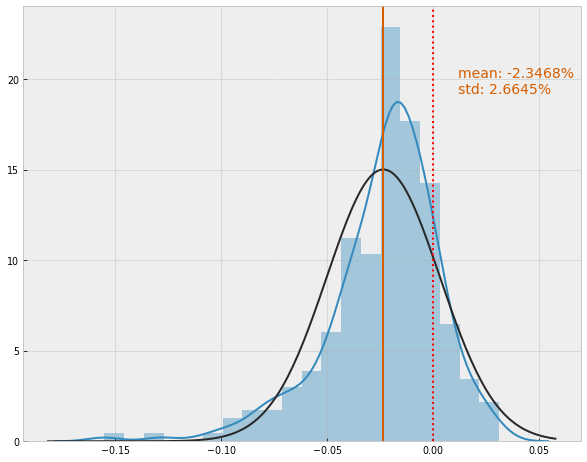

In [372]:
def plot_outlier_return_dist(df):
    sns.distplot(df.set_index('Dates'), fit=stats.norm)
    plt.axvline(df['cuml_returns'].mean(), color=red)
    plt.axvline(0, color='red', ls=':')
    add_mean_std_text(df['cuml_returns'])
    
### plot ###
plot_outlier_return_dist(too_low_returns)

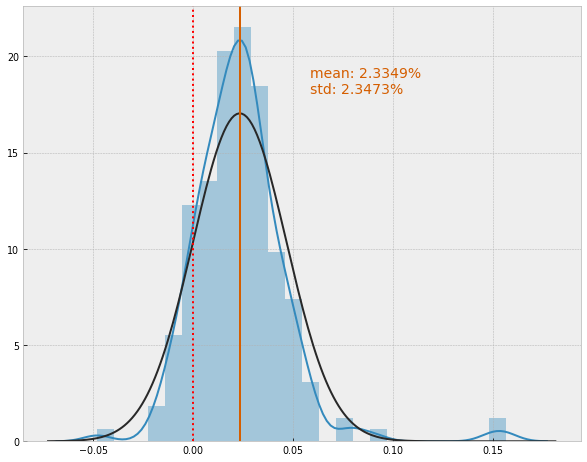

In [373]:
plot_outlier_return_dist(too_high_returns)